<a href="https://colab.research.google.com/github/NoelleI/Udacity-Deployment/blob/master/Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:


'''Step 1 Detect Skin 
this code was adapted from https://www.pyimagesearch.com/2014/08/18/skin-detection-step-step-example-using-python-opencv/
and
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/'''

# import the necessary packages
import imutils
import numpy as np
import argparse
import cv2
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
# construct the argument parse and parse the arguments

# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin'
lower = np.array([0, 0, 0], dtype = "uint8")
upper = np.array([255, 255, 255], dtype = "uint8")
# if a video path was not supplied, grab the reference
# to the gray


camera = cv2.VideoCapture("skin_detect.MOV")  
n_frames = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
print(n_frames)

''''change this'''


ra = []
ga = []
ba = []
box = []

# keep looping over the frames in the video
for i in range(n_frames):
    
    print(i)
	# grab the current frame
    (grabbed, frame) = camera.read()
	# if we are viewing a video and we did not grab a
	# frame, then we have reached the end of the video
	# resize the frame, convert it to the HSV color space,
	# and determine the HSV pixel intensities that fall into
	# the speicifed upper and lower boundaries
    if grabbed:
        frame = imutils.resize(frame, width = 400)
        frame = imutils.rotate(frame, -90)
        converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        skinMask = cv2.inRange(converted, lower, upper)
	# apply a series of erosions and dilations to the mask
	# using an elliptical kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        skinMask = cv2.erode(skinMask, kernel, iterations = 2)
        skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
	# blur the mask to help remove noise, then apply the
	# mask
        skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
        skin = cv2.bitwise_and(frame, frame, mask = skinMask)

        bboxes = classifier.detectMultiScale(skin, 1.05, 8)
        print('len bboxes:', len(bboxes))
        if box == []:  
          if len(bboxes) ==0:
            print("face not detected in first frame")
            cv2_imshow(np.vstack([frame, skin]))  ##change to an assert later
          else:
            box = bboxes[0]
#choose the box most like the last frame, if more than one box. If zero boxes, use box from last frame
        else:
          if len(bboxes) ==0:
            box = box   
            print("old box used") 
          else:
           test2 = np.zeros(len(bboxes))
           for i, boxnew in enumerate(bboxes):
            [xn, yn, widthn, heightn] = boxnew 
            x2n = xn + widthn
            y2n = yn + heightn
           	# draw a rectangle mask and compare to box from previous frame
            tempn = np.zeros([frame.shape[0], frame.shape[1]])
            tempn = tempn.astype(np.uint8)
            cv2.rectangle(tempn, (xn, yn), (x2n, y2n), (255,255,255), -1)
            test = cv2.bitwise_and(temp, temp, mask = tempn)
            test2[i] = np.mean(test)
           boxt = bboxes[np.argmax(test2)]
           if boxt[3] <= width*0.9 or boxt[3] >= width*1.1:
             box = box
             print("old box used")
           else:
             box = boxt
             print("nearest box used")
	# extract
        [x, y, width, height] = box 
        x2 = x + width
        y2 = y + height
        x2 = int(x2 - 0.2*width)
        x = int(x + 0.2*width)
        #y2 = int(y2 - 0.8*height)
           	# draw a rectangle over the pixels
        temp = np.zeros([frame.shape[0], frame.shape[1]])
        cv2.rectangle(temp, (x, y), (x2, y2), (255,255,255), -1)
        temp = temp/255
        temp = temp.astype(np.uint8)
        skin = cv2.bitwise_and(skin, skin, mask = temp)



        #find the average red, green and blue in the skin
        N = 0
        r=0
        g=0
        b=0
        skinr = skin[:,:,0].reshape(-1)
        sking = skin[:,:,1].reshape(-1)
        skinb = skin[:,:,2].reshape(-1)

        #print(skinMask.shape)
        for i, pixel in enumerate(skinMask.reshape(-1)):
          if  not pixel==0:
            r += skinr[i]
            g += sking[i]
            b += skinb[i]
            N+=1
        ra += [r/N] 
        ga += [g/N]
        ba += [b/N]




	# show the skin in the image along with the mask
      
        #cv2_imshow(np.vstack([frame, skin]))
# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

1833
0
len bboxes: 1
1
len bboxes: 1
nearest box used


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Streaming output truncated to the last 5000 lines.
len bboxes: 1
nearest box used
166
len bboxes: 1
nearest box used
167
len bboxes: 1
nearest box used
168
len bboxes: 1
nearest box used
169
len bboxes: 1
nearest box used
170
len bboxes: 1
nearest box used
171
len bboxes: 1
nearest box used
172
len bboxes: 1
nearest box used
173
len bboxes: 1
nearest box used
174
len bboxes: 1
nearest box used
175
len bboxes: 1
nearest box used
176
len bboxes: 1
nearest box used
177
len bboxes: 1
nearest box used
178
len bboxes: 1
nearest box used
179
len bboxes: 1
nearest box used
180
len bboxes: 1
nearest box used
181
len bboxes: 1
nearest box used
182
len bboxes: 1
nearest box used
183
len bboxes: 1
nearest box used
184
len bboxes: 1
nearest box used
185
len bboxes: 1
nearest box used
186
len bboxes: 1
nearest box used
187
len bboxes: 1
nearest box used
188
len bboxes: 1
nearest box used
189
len bboxes: 1
nearest box used
190
len bboxes: 1
nearest box used
191
len bboxes: 1
nearest box used
192
len 

In [57]:
ra = np.array(ra)

In [58]:
np.argmin(ra)

1822

In [59]:
ra[np.argmin(ra)]

21.948433333333334

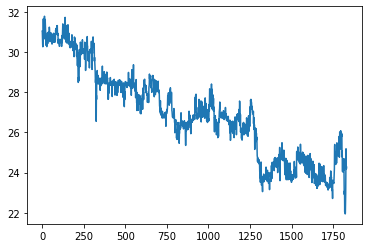

In [60]:
import matplotlib.pyplot as plt

plt.plot(ra)

In [61]:
ga = np.array(ga)
ba = np.array(ba)

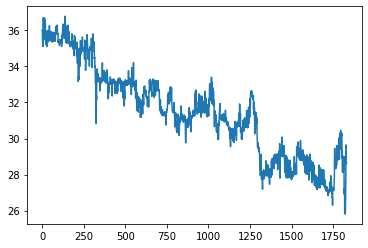

In [62]:
plt.plot(ga)

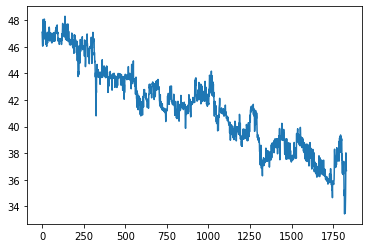

In [63]:
plt.plot(ba)

In [64]:
from sklearn.decomposition import FastICA
from scipy import signal
transformer = FastICA(n_components=3)

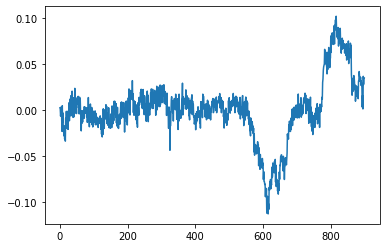

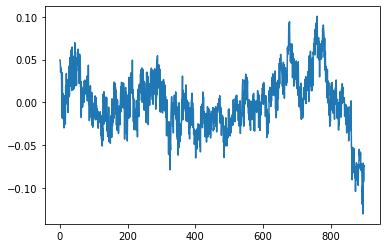

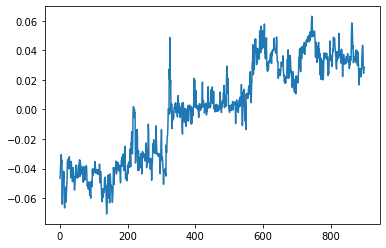

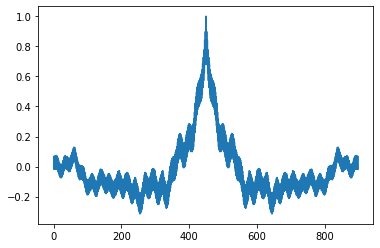

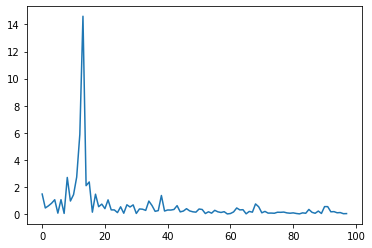

14.609379399208688 2.697341631118051
estimated heartrate  70.0


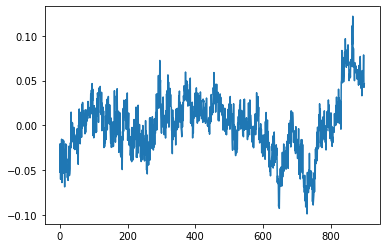

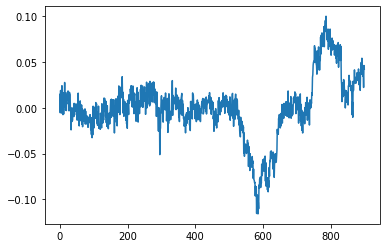

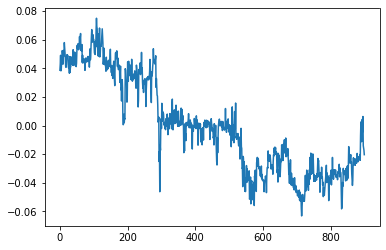

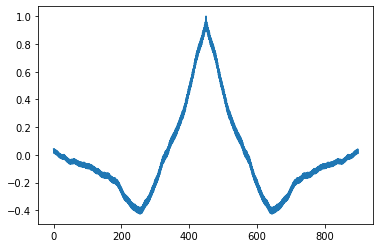

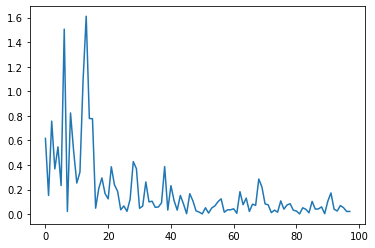

1.6110988846524215 1.5063994054317957
waiting


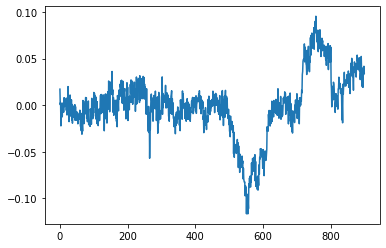

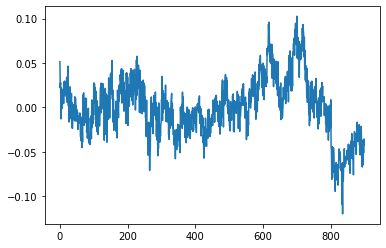

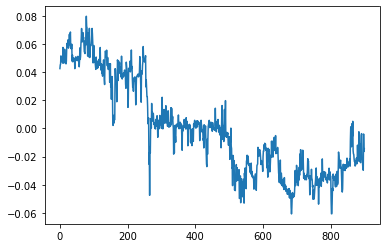

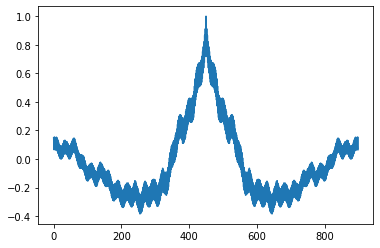

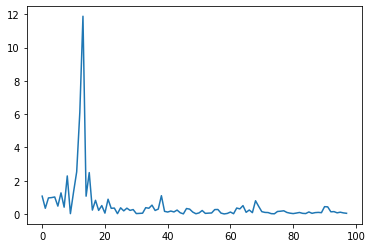

11.87894267204699 2.4885359392135062
estimated heartrate  70.0


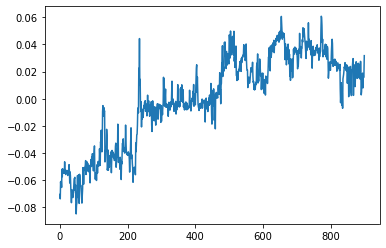

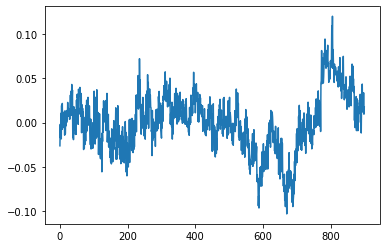

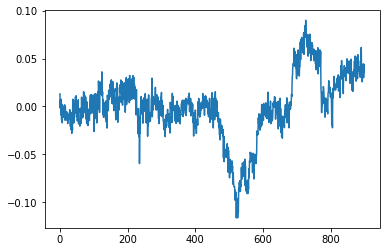

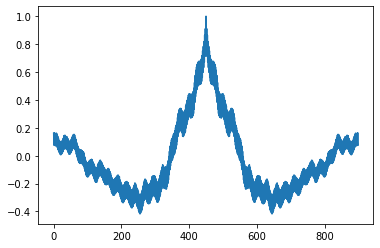

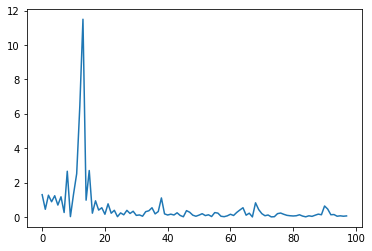

11.49809415420079 2.7014237098735494
estimated heartrate  70.0


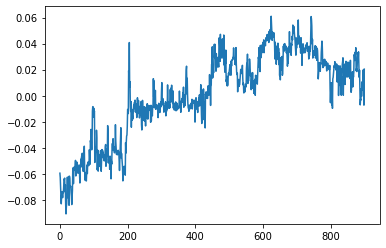

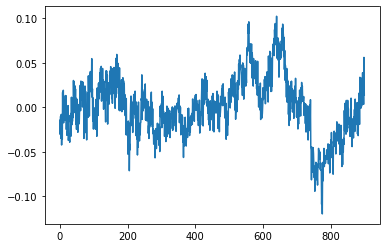

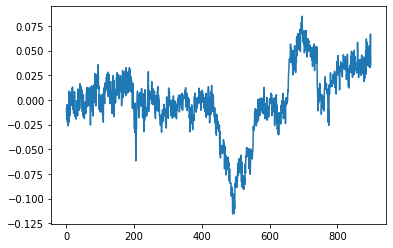

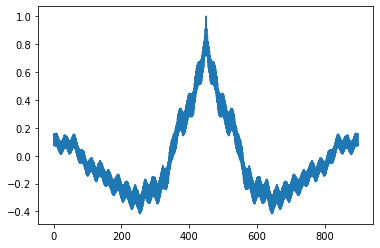

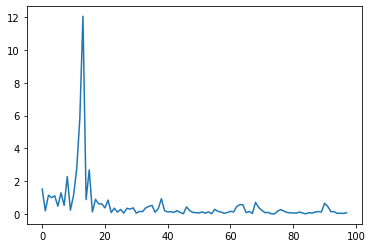

12.06224704088297 2.68659034779806
estimated heartrate  70.0


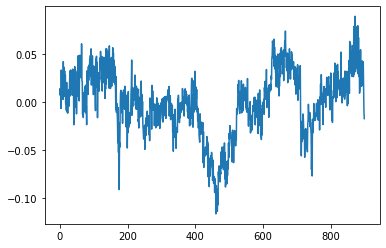

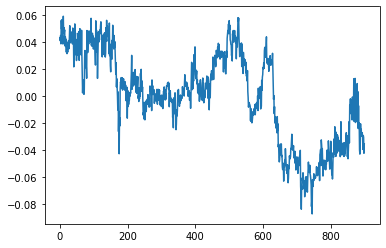

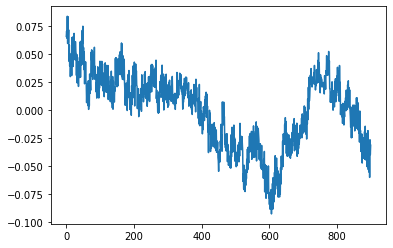

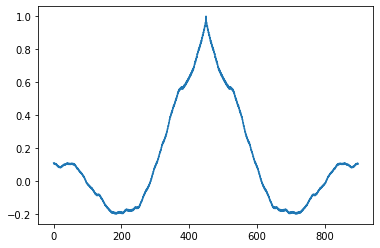

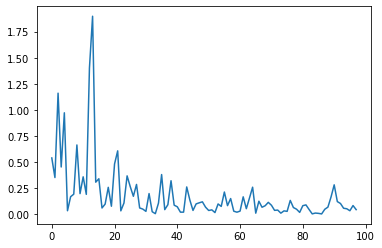

1.8975010883265506 1.1593806644507223
waiting


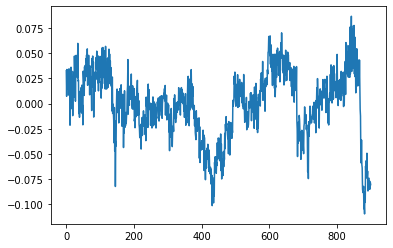

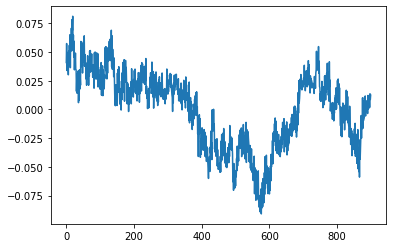

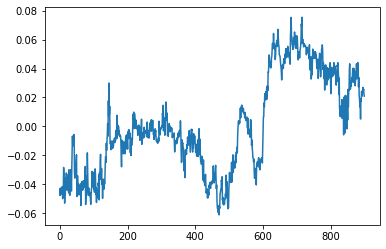

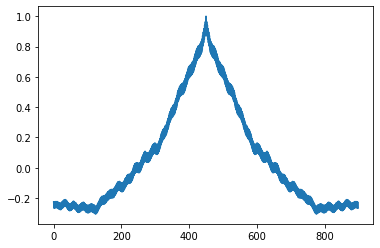

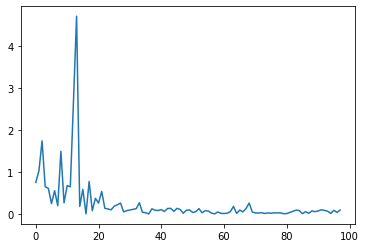

4.7043992968971144 1.7389109761928594
estimated heartrate  70.0


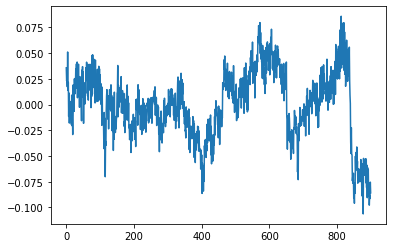

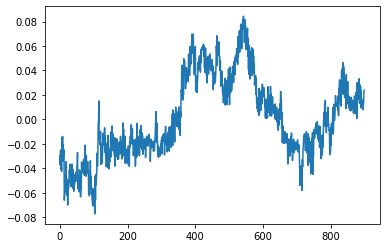

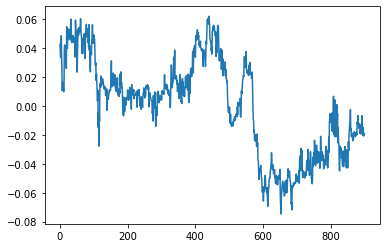

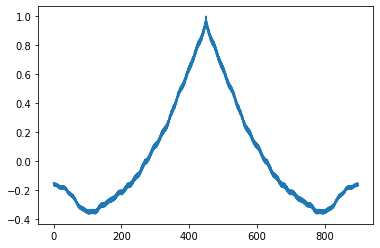

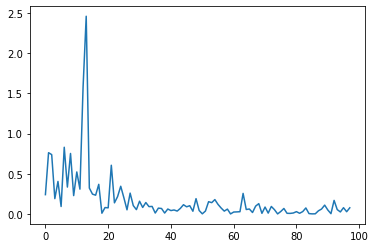

2.4602174273110053 0.8303923262450906
estimated heartrate  70.0


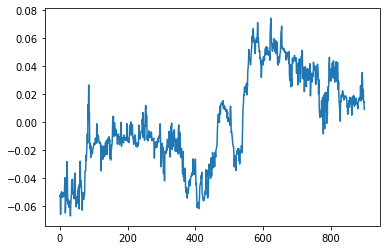

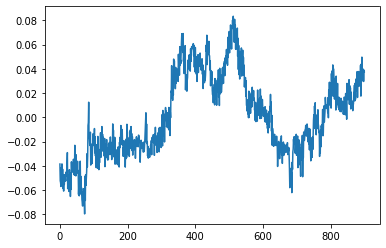

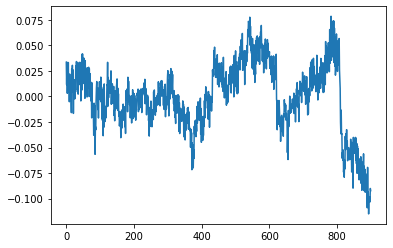

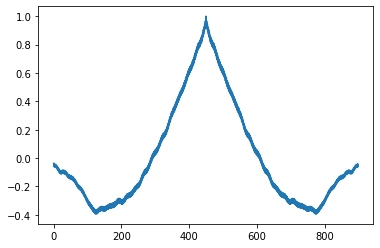

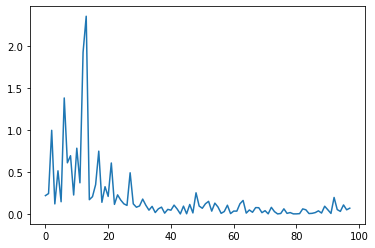

2.3537061221398368 1.3812618158964034
estimated heartrate  70.0


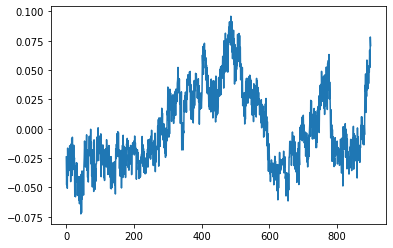

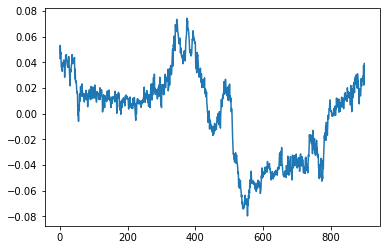

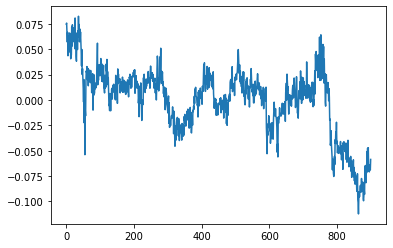

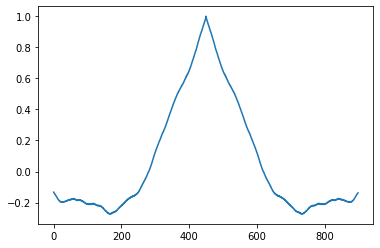

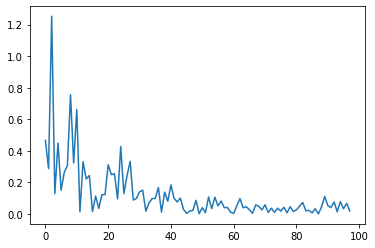

1.2531223909958333 0.7559324061327148
waiting


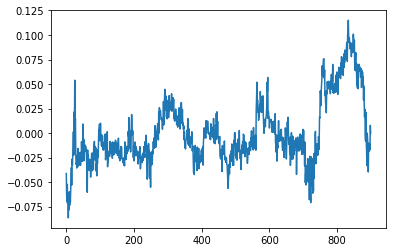

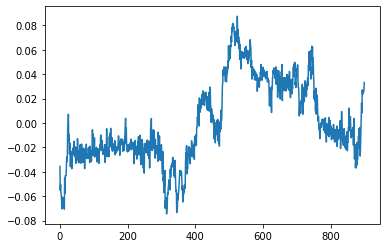

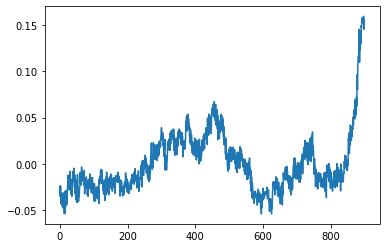

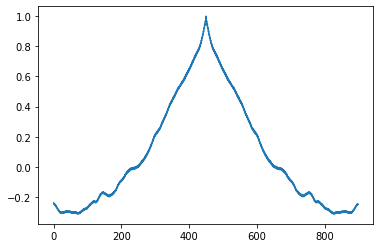

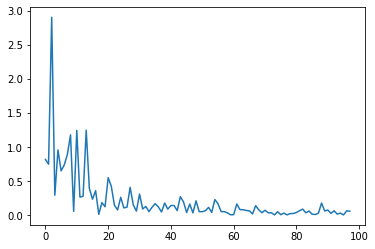

2.9027596436360668 1.246149948869532
estimated heartrate  48.0


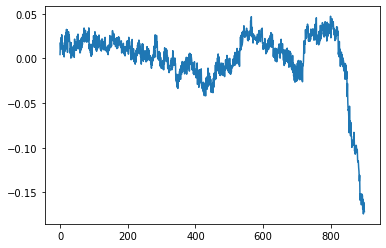

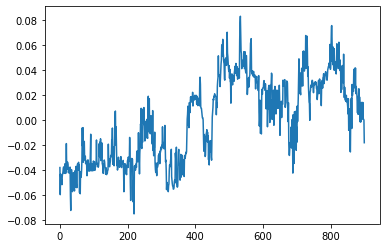

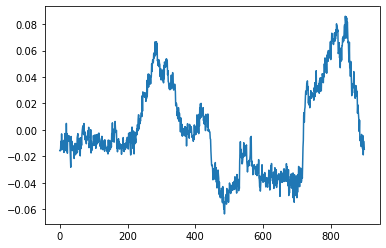

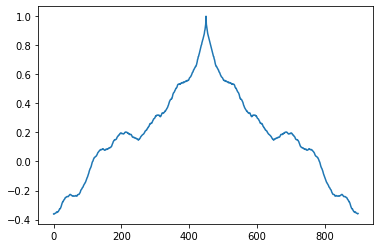

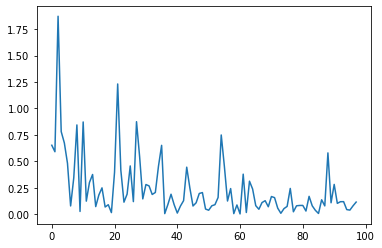

1.8728888522109706 1.2319455864129474
waiting


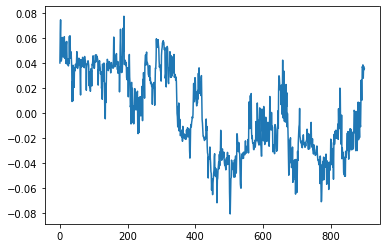

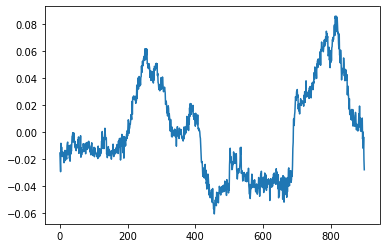

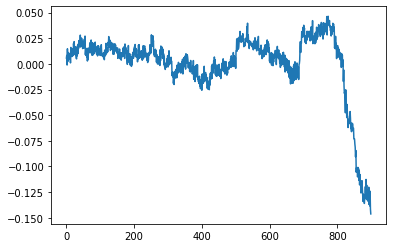

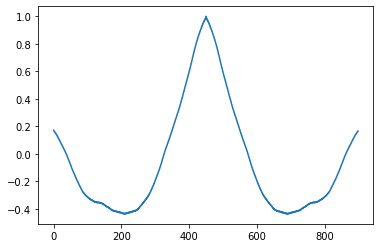

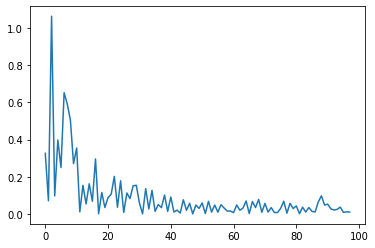

1.0622403543723844 0.6512653227660483
waiting


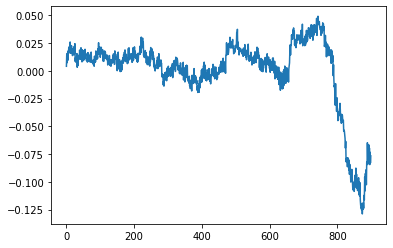

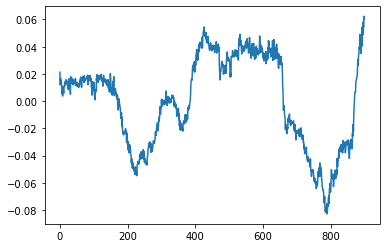

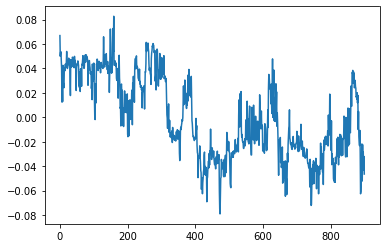

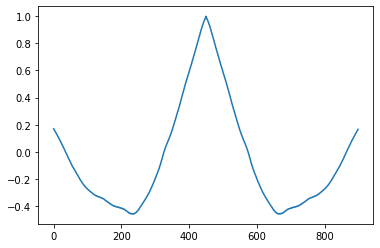

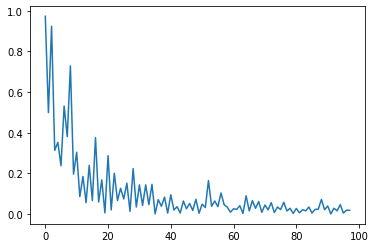

0.9733097352925931 0.9242345952464006
waiting


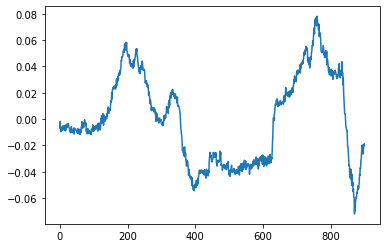

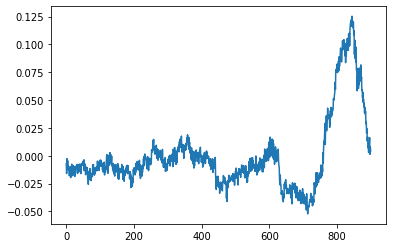

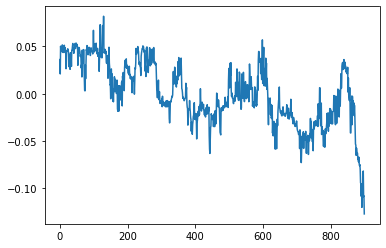

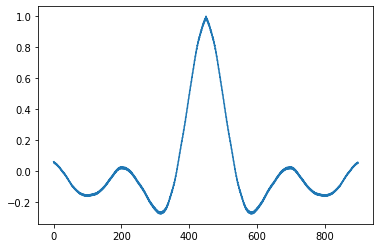

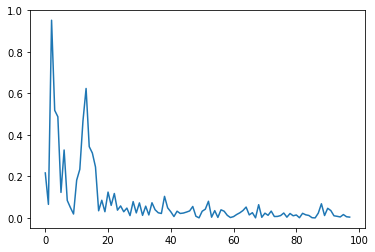

0.9524170701426319 0.6237230968009239
waiting


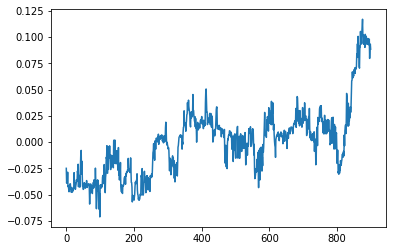

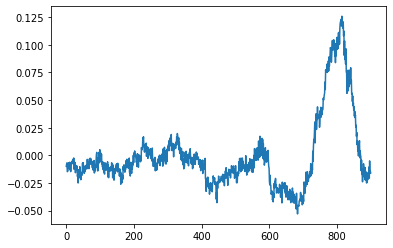

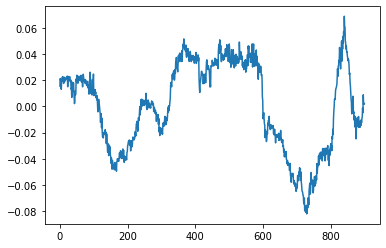

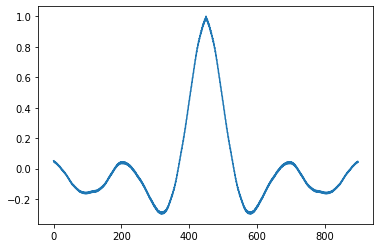

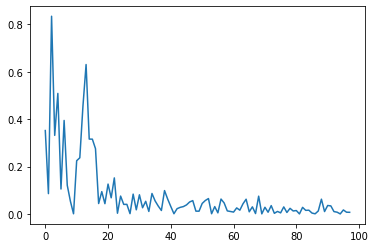

0.833957158938329 0.6303335906093407
waiting


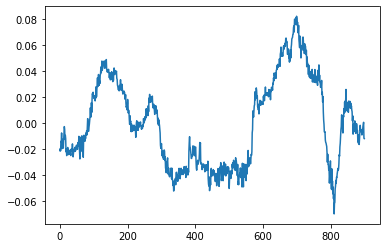

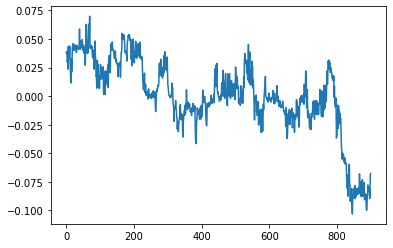

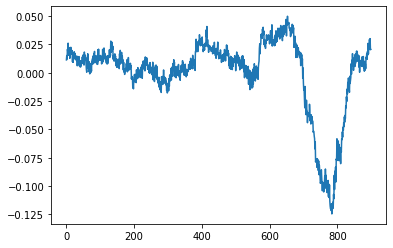

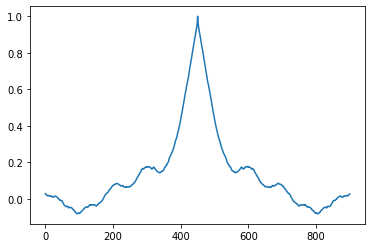

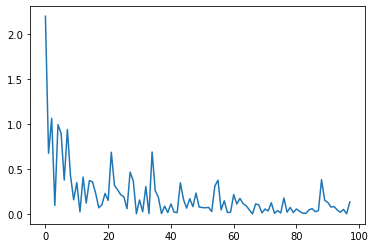

2.198689490708966 1.0622966973430947
estimated heartrate  44.0


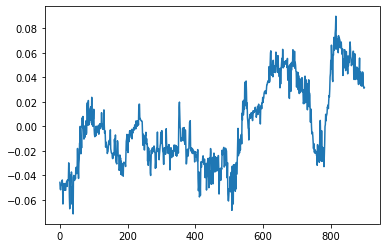

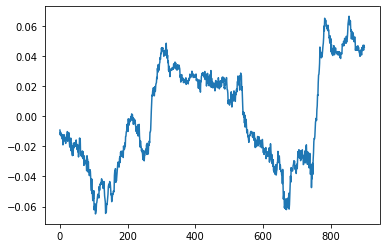

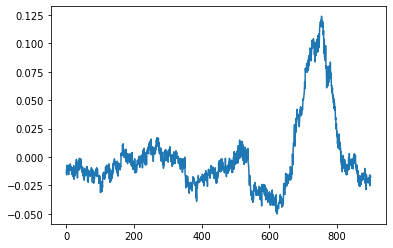

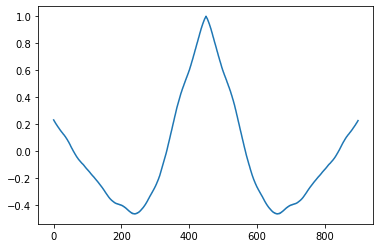

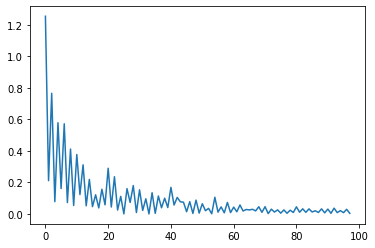

1.2543863335663004 0.765544297918177
waiting


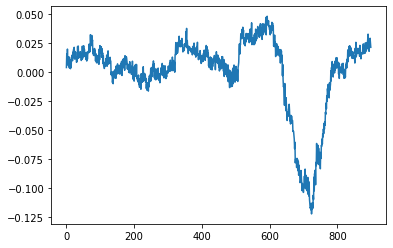

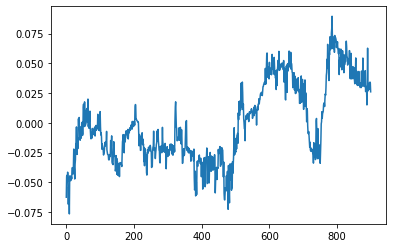

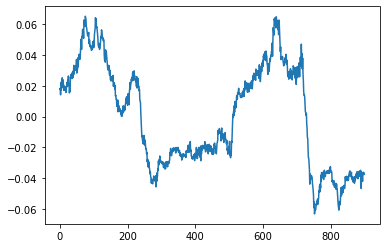

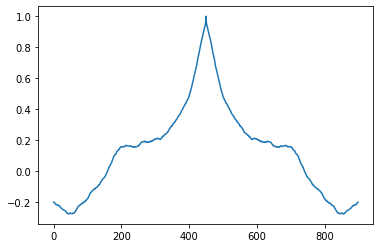

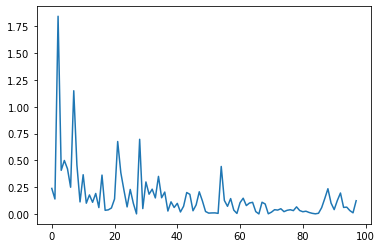

1.8431092917754428 1.1485772195628259
waiting


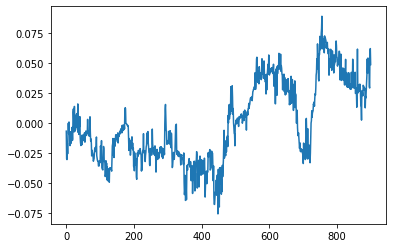

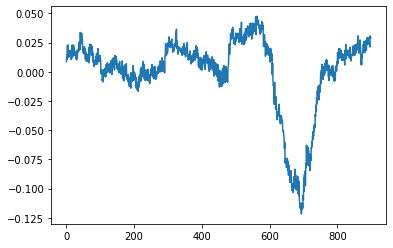

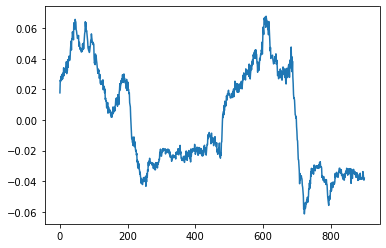

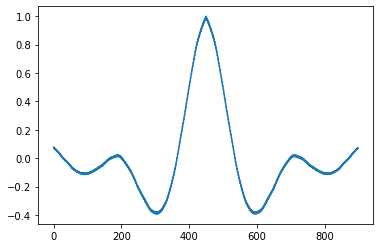

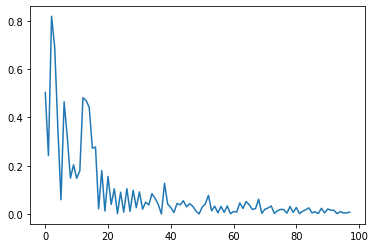

0.8187542277322711 0.4814215607245468
estimated heartrate  48.0


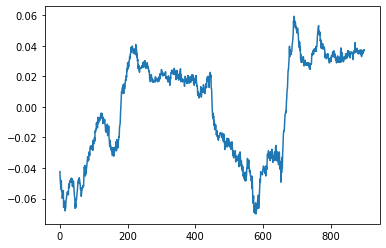

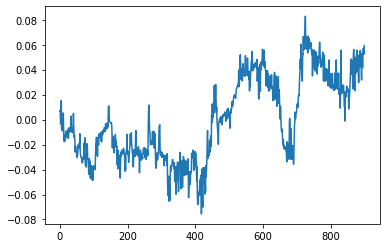

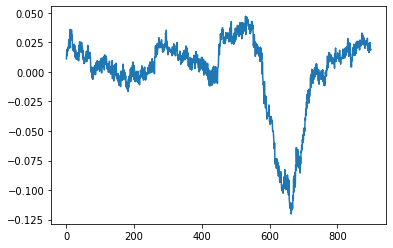

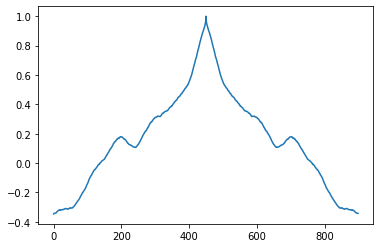

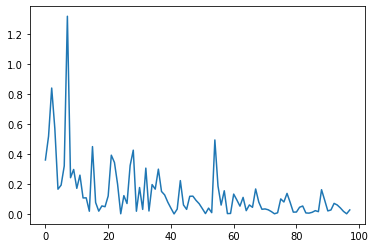

1.319610193413381 0.8416624267672219
waiting


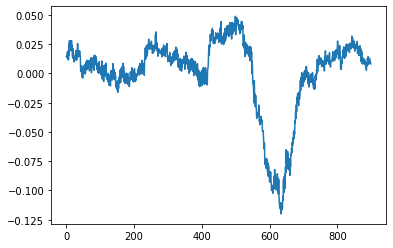

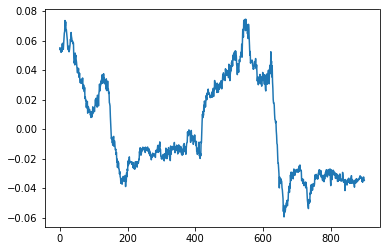

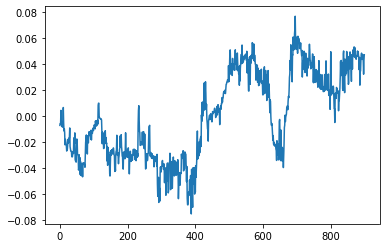

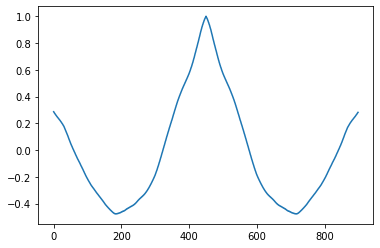

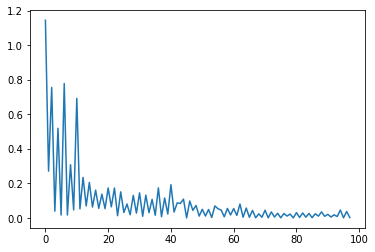

1.1444131696642499 0.7781755927422509
waiting


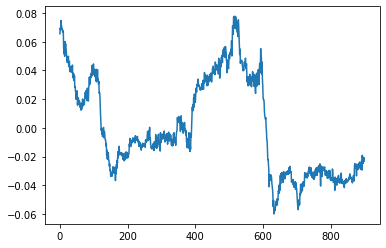

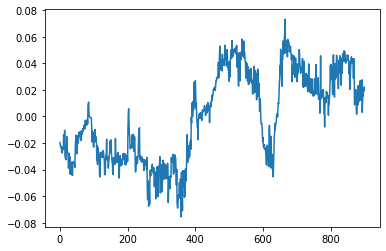

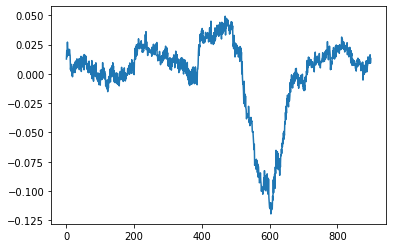

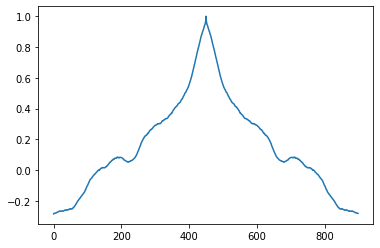

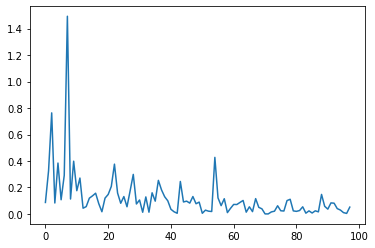

1.493580171457134 0.763498947598306
estimated heartrate  58.0


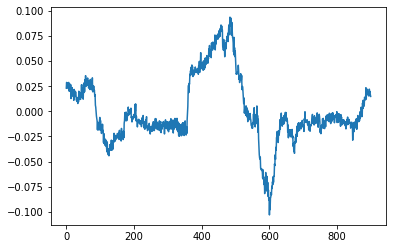

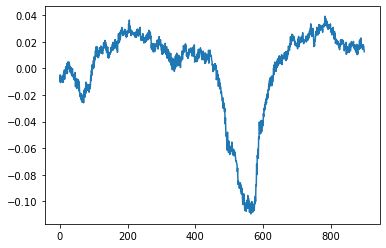

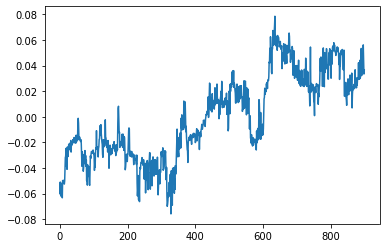

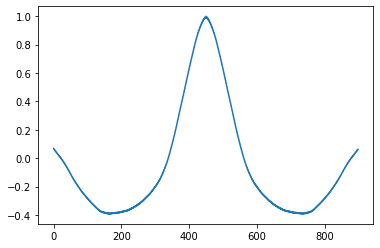

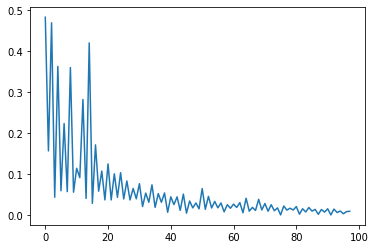

0.4832466795066522 0.4696898198268523
waiting


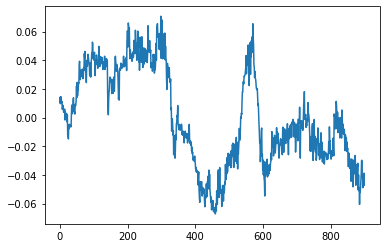

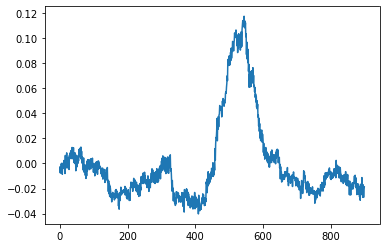

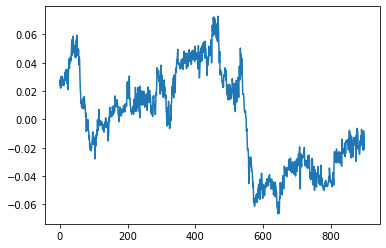

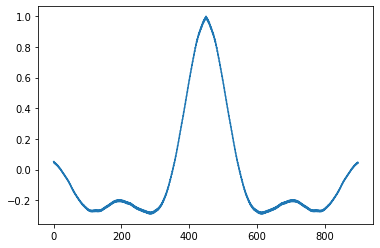

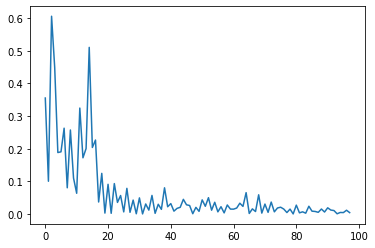

0.6054662869081411 0.5101850503165702
waiting


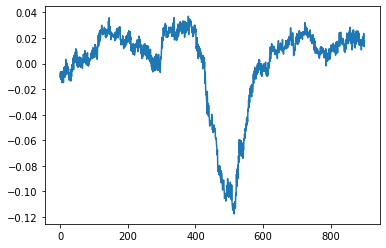

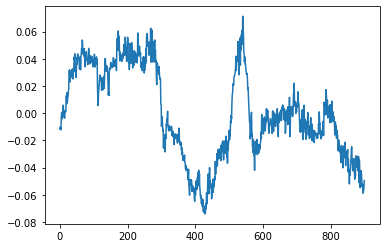

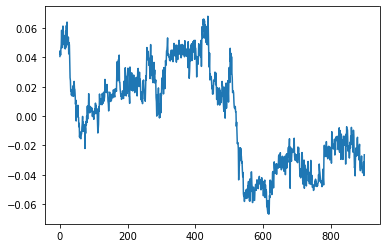

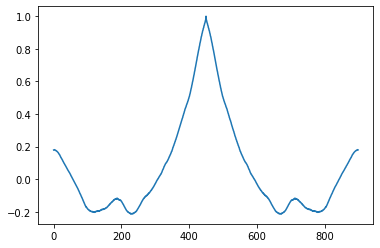

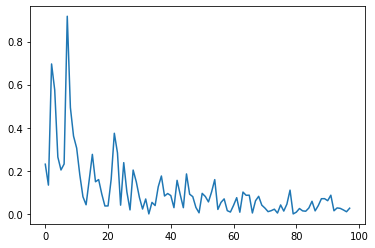

0.9171437747433977 0.6958542389493367
waiting


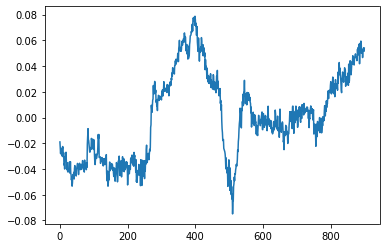

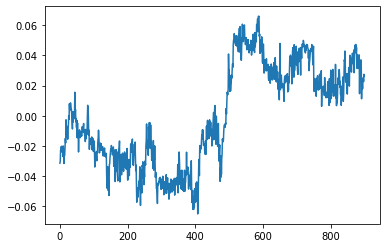

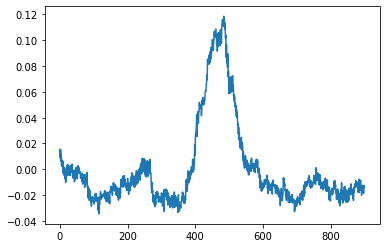

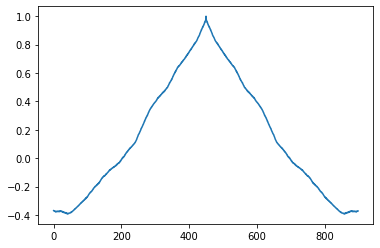

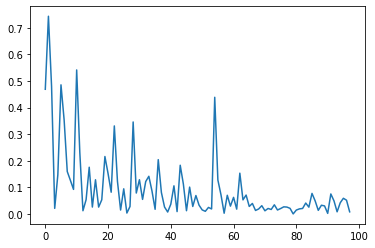

0.7434637924466738 0.5416699951981677
waiting


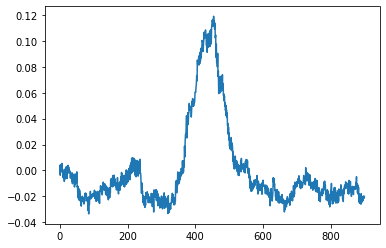

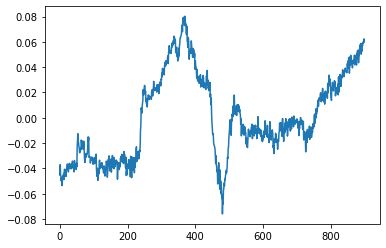

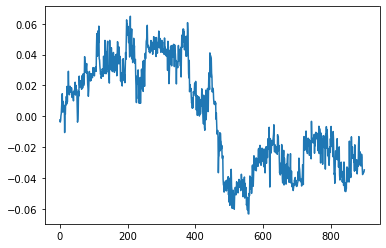

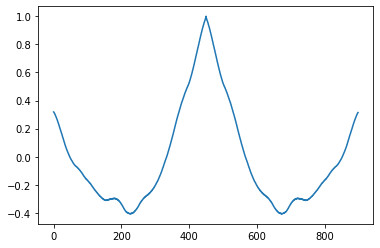

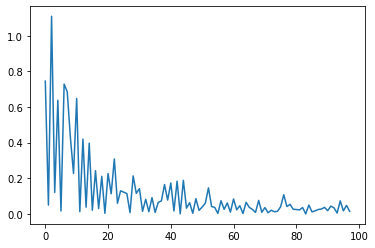

1.10938983930643 0.7288800722986274
waiting


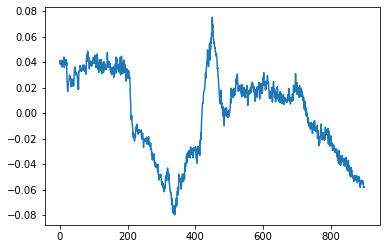

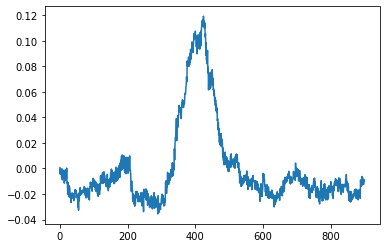

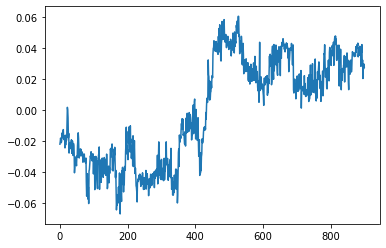

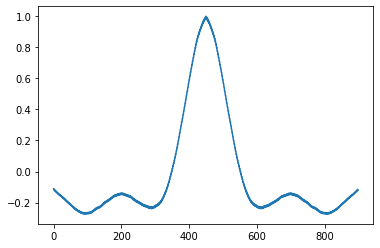

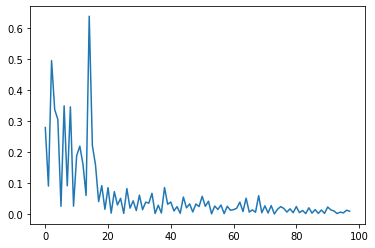

0.639384538506135 0.4958516320449339
waiting


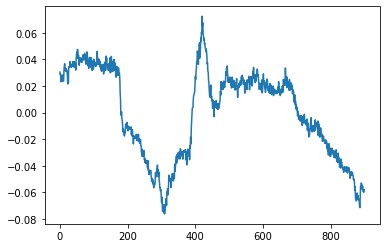

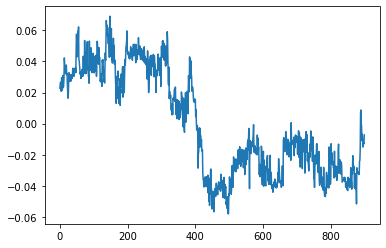

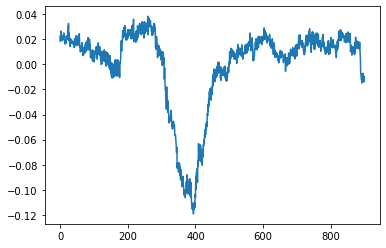

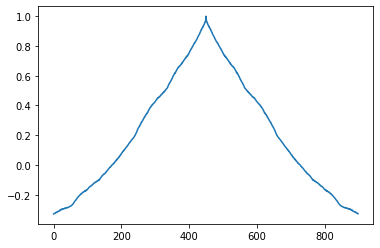

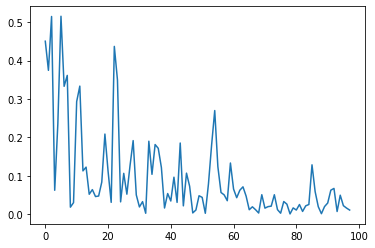

0.5153486769923281 0.5147022871545021
waiting


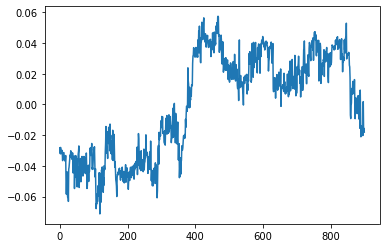

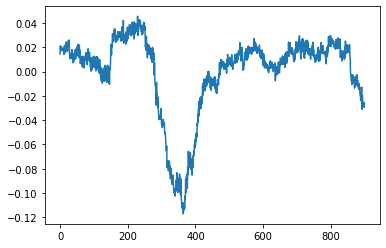

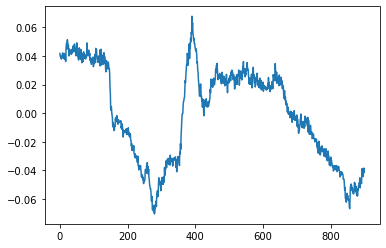

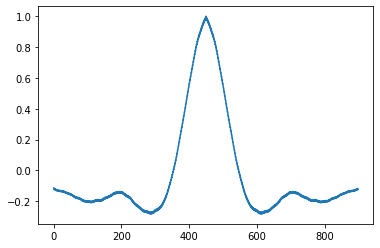

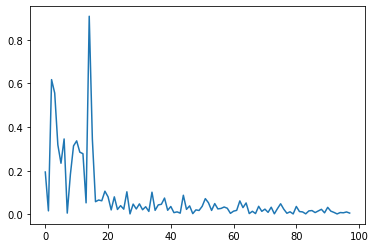

0.9077740820018022 0.6174133093813156
waiting


In [65]:
#normalize over 30s windows as in Poe et al.
n30 = int((n_frames - 900)/30) #number of 30 second sliding windows
ran = np.zeros(900)
gan = np.zeros(900)
ban = np.zeros(900)
for i in range(n30):
  rav = np.mean(ra[i*30:i*30+900])
  gav = np.mean(ga[i*30:i*30+900])
  bav = np.mean(ba[i*30:i*30+900])
  rstd = np.std(ra[i*30:i*30+900])
  gstd = np.std(ga[i*30:i*30+900])
  bstd = np.std(ba[i*30:i*30+900])
  for j in range(900):
    ran[j] = (ra[i*30 + j] - rav)/rstd
    gan[j] = (ga[i*30 + j] - gav)/gstd
    ban[j] = (ba[i*30 + j] - bav)/bstd
  X = np.array(list(zip(ran,gan,ban)))
  X_transformed = transformer.fit_transform(X)
  X_indep = X_transformed.transpose()
  plt.plot(X_indep[0])
  plt.show()
  plt.plot(X_indep[1])
  plt.show()
  plt.plot(X_indep[2])
  plt.show()
  x1 = X_indep[1]
  x1_corr = signal.correlate(x1, x1, mode='same')
  plt.plot(x1_corr)
  plt.show()
  ff = np.fft.hfft(x1_corr[:int(len(x1_corr)/2)])
  fs_n = 30/len(x1_corr/2)
  upper = int(4/fs_n)
  lower = int(0.75/fs_n)
  plt.plot((abs(ff[lower:upper])))
  plt.show()
  hr1 = int((np.argmax(abs(ff[lower:upper])) + lower))
  max1 = np.max(abs(ff[lower:upper]))
  hr2array = np.concatenate([ff[lower:hr1 - 2], ff[hr1 + 2:upper]], axis = 0)
  max2 = np.max(abs(hr2array))
  print(max1, max2)
  if max2 <= 0.6*max1:
    hr1 = hr1*60*fs_n
    print("estimated heartrate ", hr1)
  else:
    print("waiting")



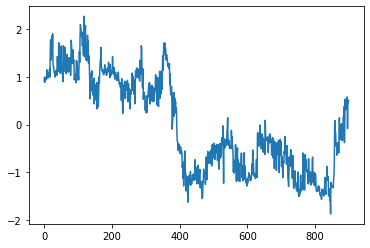

In [66]:
plt.plot(ran)

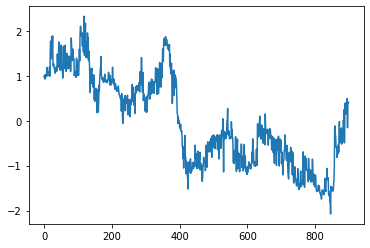

In [67]:
plt.plot(gan)

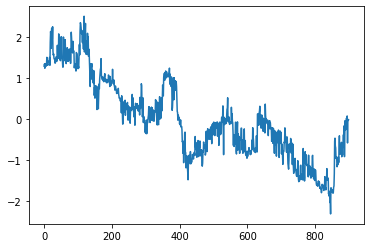

In [68]:

plt.plot(ban)